<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/image_segmentation3(20230309_v3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from keras.models import Model, load_model
from keras.layers import Input, Resizing,Rescaling
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [36]:
# split dataset into 85% train, 10% validation and 5% test
# during training create a validation set from training set
dataset,info = tfds.load('oxford_iiit_pet:3.*.*', 
                                split=['train+test[:70%]',
                                       'test[70%:90%]',
                                       'test[90%:]'],
                                with_info=True)

In [37]:
print(f'Number of images/masks in train set: {len(dataset[0])}')
print(f'Number of images/masks in validation set: {len(dataset[1])}')
print(f'Number of images/masks in test set: {len(dataset[2])}')



Number of images/masks in train set: 6248
Number of images/masks in validation set: 734
Number of images/masks in test set: 367


In [4]:
type(dataset[0])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [38]:
# Function to Normalize pixel values to 0 to 1 from 0 to 255 and subtract 1 from
# the segmentation mask, resulting in labels that are : {0, 1, 2} from {1,2,3}
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [39]:
# Function to resize images and segmentation masks to 128 X 128
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [40]:
# Normalize image pixels to 0 to 1 and resize images and masks to 128 X 128
train_images = dataset[0].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_images = dataset[1].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset[2].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [41]:
type(train_images)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [42]:
BUFFER_SIZE = 100
BATCH_SIZE = 64

In [43]:
# Build the input pipeline
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

validation_batches = (
    validation_images
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

test_batches = (
    test_images
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [44]:
def display(data_list):
  plt.figure(figsize=(16,8))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(data_list)):
    plt.subplot(1, len(data_list), i+1)
    plt.title(title[i])
    plt.imshow(data_list[i])
    plt.axis('off')
  plt.show()


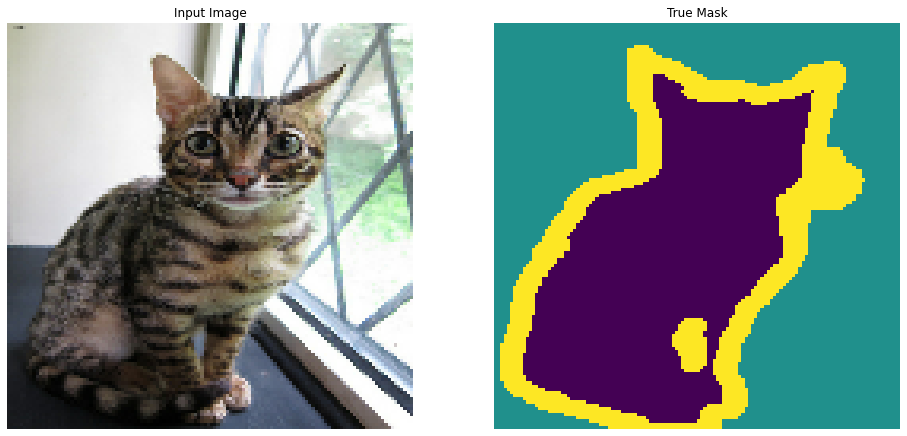

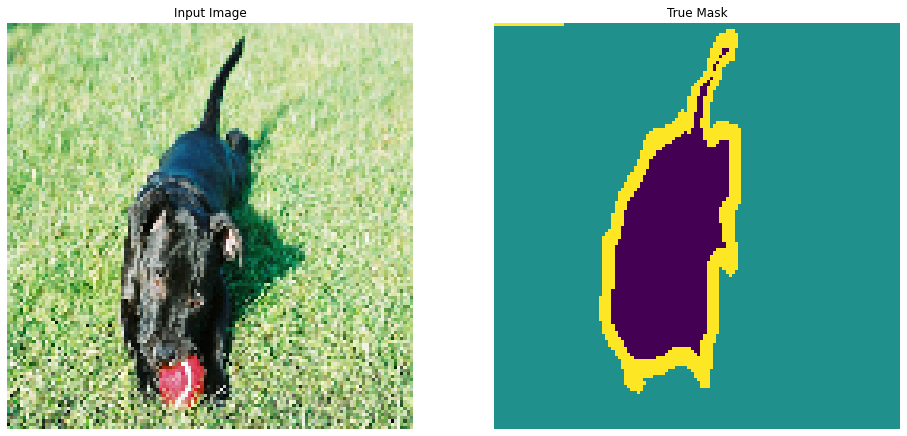

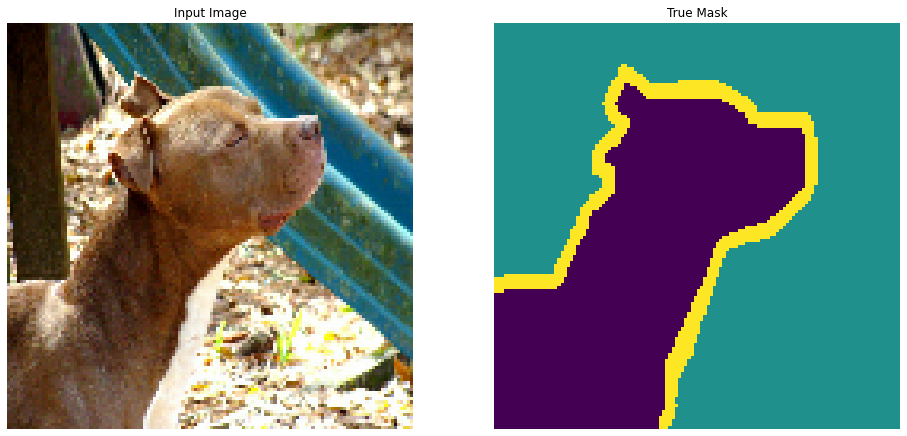

In [45]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [46]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

In [47]:
def get_model():
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

  # Downsampling (encodere)
  c1 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c5)

  # upsampling (Decoder)
  # may need to change kernel_size to (3,3)?
  u6 = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same') (c5)
  u6 = Concatenate()([u6, c4])
  c6 = Conv2D(filters=128, kernel_size=(3, 3),activation='elu', 
              kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same') (c6)
  u7 = Concatenate()([u7, c3])
  c7 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same') (c7)
  u8 = Concatenate()([u8, c2])
  c8 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), 
                       padding='same') (c8)
  u9 = Concatenate()([u9,c1]) # get rid of (axis=3)?
  c9 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu', 
              kernel_initializer='he_normal', padding='same') (c9)

  # Last / top layer
  outputs = Conv2D(filters=3, kernel_size=(1, 1),activation='tanh') (c9)
  #outputs = Conv2DTranspose(filters=3, kernel_size=(3,3), strides=(2,2),
  #    padding='same')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [69]:
unet_model = get_model()

In [117]:
lr = 0.001

#
unet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',
                       tf.keras.metrics.MeanIoU(num_classes=3,
                                                  sparse_y_pred = False)])

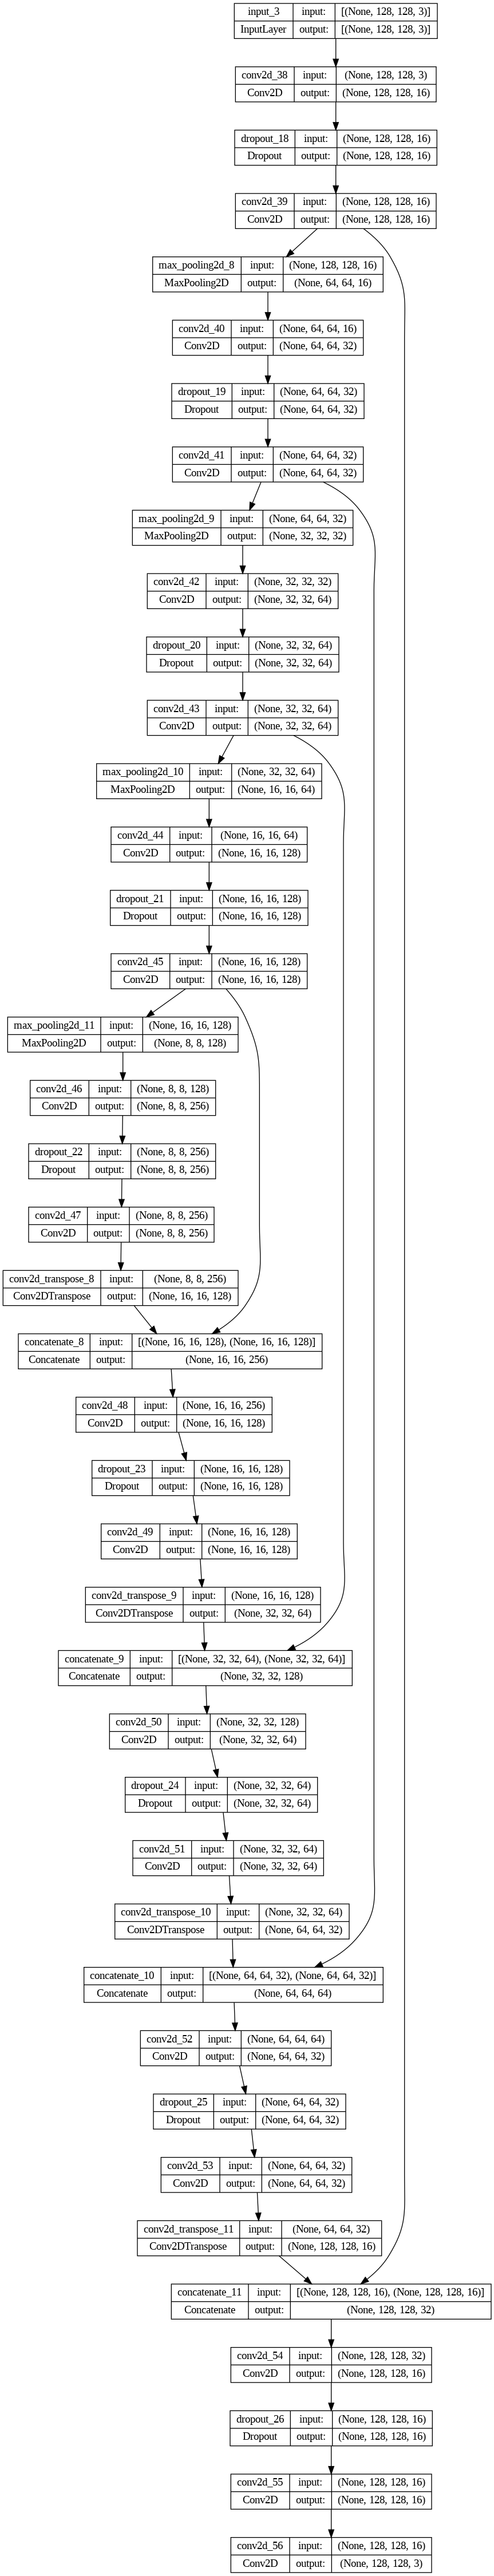

In [71]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [72]:
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 128, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

In [73]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [74]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 367ms/step


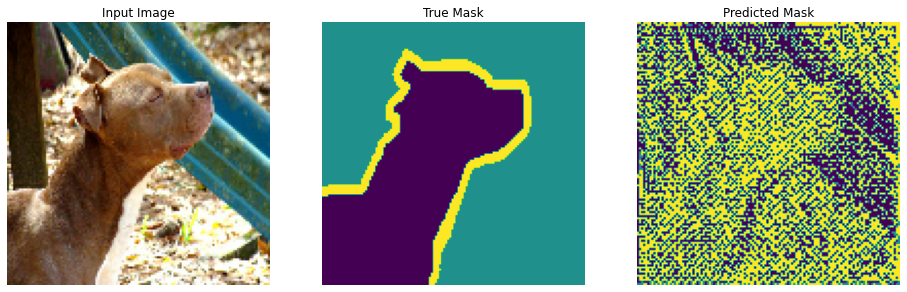

In [75]:
# show model predictions before training
show_predictions()

In [76]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [118]:
filepath = "unet_model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

callbacks_list = [earlystopper,checkpoint,reduce_lr,DisplayCallback()]

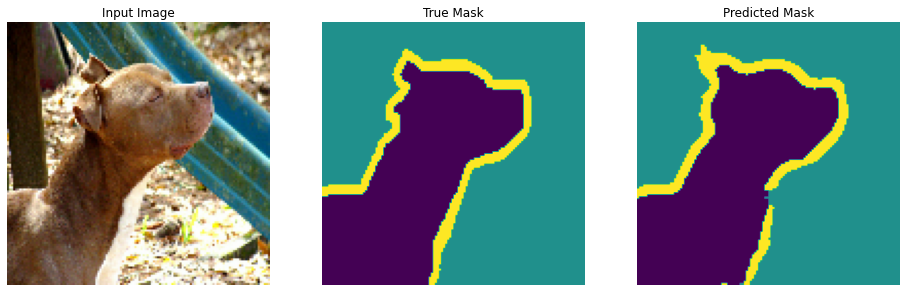


Sample Prediction after epoch 22

98/98 [==============================] - 20s 201ms/step - loss: 0.3575 - accuracy: 0.9279 - mean_io_u_5: 0.7848 - val_loss: 0.4368 - val_accuracy: 0.8864 - val_mean_io_u_5: 0.7156 - lr: 0.0010
Epoch 22: early stopping


In [119]:
EPOCHS = 30


model_history = unet_model.fit(train_batches, epochs=EPOCHS,
                          validation_data=test_batches,
                          callbacks=callbacks_list)

In [120]:
var = list(model_history.history.keys())
var

['loss',
 'accuracy',
 'mean_io_u_5',
 'val_loss',
 'val_accuracy',
 'val_mean_io_u_5',
 'lr']

In [121]:
def show_history(model_history):
  
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  mean_iou = model_history.history[var[2]]
  val_mean_iou = model_history.history[var[5]]
  

  epochs_range = model_history.epoch

  plt.figure(figsize=(14, 6))

  plt.subplot(1,3,1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')

  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')


  plt.subplot(1, 3, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')

  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')


  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, mean_iou, label='Training Mean_IoU')
  plt.plot(epochs_range, val_mean_iou, label='Validation Mean_IoU')

  plt.legend(loc='lower right')
  plt.title('Training and Validation Mean IoU')
  plt.show()

  train_acc = model_history.history['accuracy'][-1]
  val_acc = model_history.history['val_accuracy'][-1]
  train_loss = model_history.history['loss'][-1]
  val_loss = model_history.history['val_loss'][-1]
  train_meanIoU = model_history.history[var[2]][-1]
  val_meanIoU = model_history.history[var[5]][-1]

  print(f'Training accuracy: {train_acc:.3f}\tTraining loss: {train_loss:.3f}\tTraining Mean IoU: {train_meanIoU:.3f}')
  print(f'Validation accuracy: {val_acc:.3f}\tValidation loss: {val_loss:.3f}\tValidation Mean IoU: {val_meanIoU:.3f}')
  


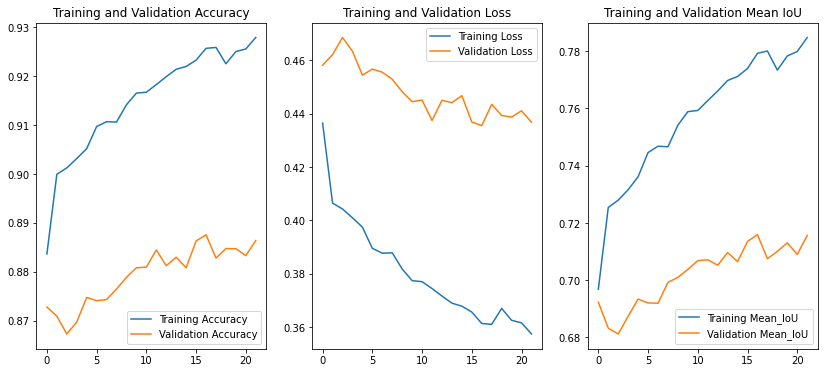

Training accuracy: 0.928	Training loss: 0.357	Training Mean IoU: 0.785
Validation accuracy: 0.886	Validation loss: 0.437	Validation Mean IoU: 0.716


In [122]:
show_history(model_history)

In [123]:
test_loss,test_accuracy,test_meaniou =  unet_model.evaluate(test_batches)

6/6 [==============================] - 0s 66ms/step - loss: 0.4368 - accuracy: 0.8864 - mean_io_u_5: 0.7156


In [124]:
print(f'Test loss: {test_loss}\nTest accuracy: {test_accuracy}\nTest MeanIoU: {test_meaniou}')

Test loss: 0.4367902874946594
Test accuracy: 0.8864020705223083
Test MeanIoU: 0.7156391143798828
